# Config

In [ ]:
УБРАТЬ СИГМОИДЫ, ПОПРОБОВАТЬ РЕГРЕССИИ С ЛИНЕЙНОЙ ФУНКЦИЕЙ

SyntaxError: ignored

In [ ]:
NUMBER_OF_REGIONS = 20
HIDDEN_LAYER_SIZE = (10, 20)

In [ ]:
DATA_SOURCES = {'Kaggle': 0       # Kaggle, initial datasource on Kaggle, processing on Google servers
                , 'Gdrive': 1     # GDRIVE, reprocessed data sources, processing on Google servers
                , 'Local': 2      # localhost, for processing on local PC
}
DATA_SOURCE = DATA_SOURCES['Local']

LOAD_MODEL = 0

# Work with datasets

Download files from Kaggle

In [ ]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  #! kaggle datasets list
  ! kaggle competitions download -c novozymes-enzyme-stability-prediction
  ! mkdir novozymes_data
  ! unzip -o novozymes-enzyme-stability-prediction.zip -d novozymes_data
  ! mkdir train/
  ! mkdir test/
  ! \cp -r novozymes_data/train.csv train/train.csv
  ! \cp -r novozymes_data/train_updates_20220929.csv train/train_exclude.csv
  ! \cp -r novozymes_data/test.csv test/test.csv

In [ ]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
from math import ceil
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  0


In [ ]:
if DATA_SOURCE == DATA_SOURCES['Local']:
  WORK_DIREKTORY = 'C:\\Novozymes\\'

  train_file = WORK_DIREKTORY + 'train.csv'
  train_excludes_file = WORK_DIREKTORY + 'train_updates_20220929.csv'
  test_file = WORK_DIREKTORY + 'test.csv'

if DATA_SOURCE == DATA_SOURCES['Gdrive']:
  from google.colab import drive
  import os
  from distutils.dir_util import copy_tree

  WORK_DIREKTORY = '/content/gdrive/MyDrive/Colab Notebooks/Novozymes/'

  train_file = WORK_DIREKTORY + 'novozymes_dataset/train.csv'
  train_excludes_file = WORK_DIREKTORY + 'novozymes_dataset/train_updates_20220929.csv'
  test_file = WORK_DIREKTORY + 'novozymes_dataset/test.csv'

  drive.mount('/content/gdrive/', force_remount=True)

if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  train_file = 'train/train.csv'
  train_excludes_file = 'train/train_exclude.csv'
  test_file = WORK_DIREKTORY + 'test/test.csv'


In [ ]:
enzime_codes = []
labels = []
test_enzime_codes = []
test_labels = []

with open(train_excludes_file, 'r') as f:
  data_exclude = np.array([x.split(',') for x in f.readlines()])
data_exclude = np.array(data_exclude[data_exclude[:, 1] != ''][1:, 0], dtype=int)

with open(train_file, 'r') as f:
  #data = np.array([x.split(',') for x in f.readlines()[1:BATCH_SIZE]])
  while True:
    row = f.readline()
    if not row:
      break
    data_row = row.split(',')  
    if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id'):
      continue
    # print(data_row)
    try:
      if int(data_row[0])%51 == 0:
        test_labels.append(float(data_row[-1].replace('\n','')))
        test_enzime_codes.append([data_row[1], data_row[2]])
      else:
        labels.append(float(data_row[-1].replace('\n','')))
        enzime_codes.append([data_row[1], data_row[2]])
    except Exception:
      print(data_row)
      raise Exception

C:\Users\hp\AppData\Local\Temp\ipykernel_5560\693542374.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id'):


# Research

Read and clean data

In [ ]:
def res_normalized(y: np.array) -> np.array:
  return y / 150

def res_sigmoid(y: np.array, step: int) -> np.array:
  #eturn 1 / (1 + np.exp(- y ))
  if step == 0:
    return 1 / (1 + np.exp(- (y - 50)/7.5))
  if step == 1:
    return 1 / (1 + np.exp(- (y + 0.0966)/15))
  if step == 2:
    return 1 / (1 + np.exp(- (y - 47.576)/15))
  if step == 3:
    return 1 / (1 + np.exp(- (y + 96.994)/15))
  if step == 4:
    return 1 / (1 + np.exp(- (y - 437.309)/15))
  return 1 / (1 + np.exp(- (y)/15))

def res_tanh(y: np.array) -> np.array:
  return np.tanh((y - 50)/10)

def res_arcsinh_norm(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)/10 + 0.5

def res_arcsinh(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)

In [ ]:
def remove_sigmoid(y: np.array, step: int) -> np.array:
  y[y == 0] = 0.0001
  if step == 0:
    return 50 - 7.5 * np.log(1/y - 1)
  if step == 1:
    return -0.0966 + 15 * np.log(1/y - 1)
  if step == 2:
    return 47.576 + 15 * np.log(1/y - 1)   
  if step == 3:
    return -96.994 + 15 * np.log(1/y - 1)   
  if step == 4:
    return  437.309 + 15 * np.log(1/y - 1)  
  return  15 * np.log(1/y - 1)
  #return - np.log(1/y - 1)

TypeError: ignored

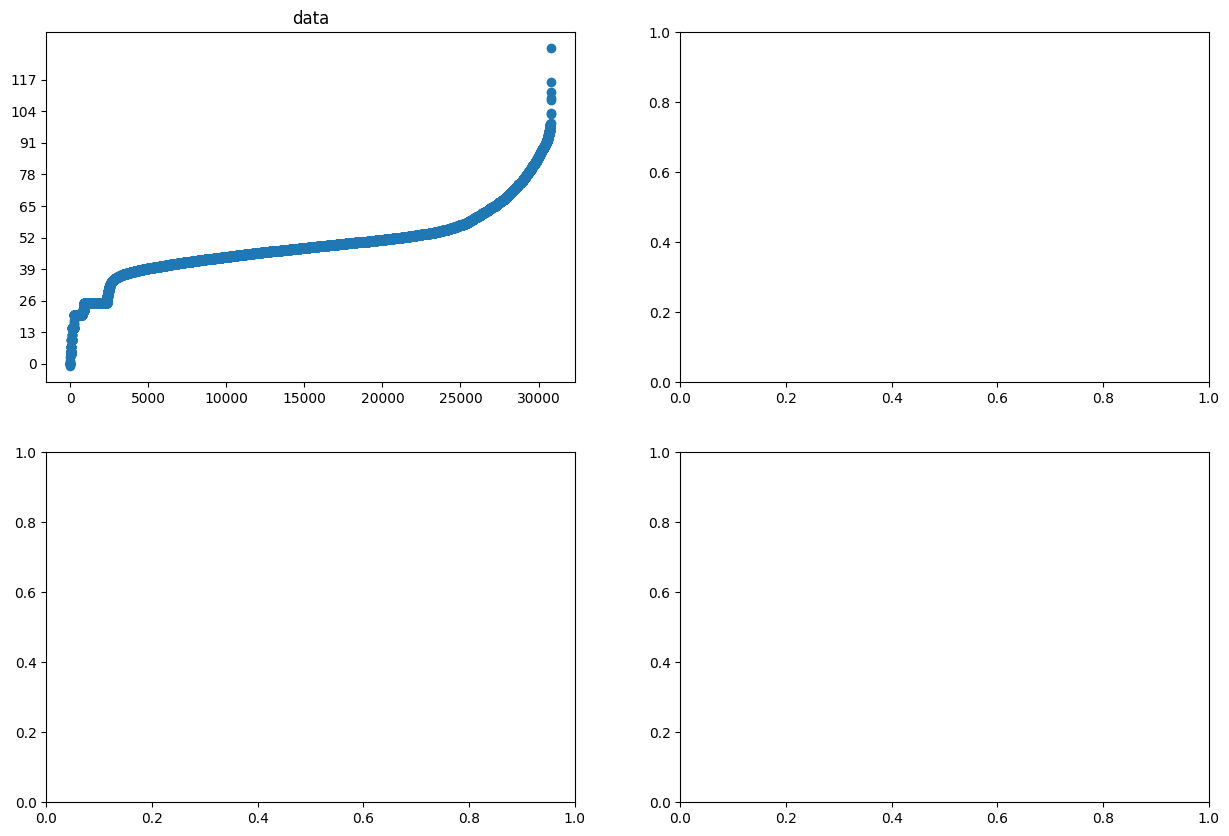

In [ ]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

y_data = np.array(labels, dtype=float)

plt.subplot(2,2,1)
plt.scatter( np.arange(0,len(y_data)), np.sort(y_data))
ax[0, 0].set(yticks=np.arange(0, 10)*np.max(y_data)/10)
plt.title('data')

plt.subplot(2,2,2)
y_sigmoid = res_sigmoid(y_data, 0) 
plt.scatter( np.arange(0,len(y_sigmoid)), np.sort(y_sigmoid))
ax[1, 0].set(yticks=np.arange(0, 10)*np.max(y_sigmoid)/10)
plt.title('sigmoid')

plt.subplot(2,2,3)
y_tanh = res_tanh(y_data) 
plt.scatter( np.arange(0,len(y_tanh)), np.sort(y_tanh))
ax[0, 1].set(yticks=np.arange(0, 10)*np.max(y_tanh)/10)
plt.title('tanh')

plt.subplot(2,2,4)
y_arcsinh = res_arcsinh(y_data) 
plt.scatter( np.arange(0,len(y_arcsinh)), np.sort(y_arcsinh))
ax[1, 1].set(yticks=np.arange(0, 10)*np.max(y_arcsinh)/10)
plt.title('arcsinh')

plt.show()

We will try to use as a labels and as result for our model **res_sigmoid(tm)** or **res_tanh(tm)** or **res_arcsinh(tm)**, cause it allows us to seek more steady solution, without some extremly low and hight cases. Shall check them all, probably.

# Convolution

In [ ]:
MAX_LENGTH = 0

# Create dictionary for protein_sequence
dictionary = {}
for d in enzime_codes:
  MAX_LENGTH = max(MAX_LENGTH, len(d[0]))
  for l in d[0]:
    if l not in dictionary:
      dictionary[l] = 0
    dictionary[l] += 1

print(len(dictionary))
vocab = np.array(sorted(dictionary.items()))[:, 0]
dictionary = tuple(enumerate(tf.constant(np.array(sorted(dictionary.items()))[:, 0])))
print(vocab)
print(MAX_LENGTH)

AMINO_ACIDS_COUNT = len(dictionary)
TEMPLATE_COUNT = pow(AMINO_ACIDS_COUNT, 2)

20
['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
32767


In [ ]:
"""
enzime_data = []
tm_data = []
string_data = []
for str in data:
  string_data.append(str[1])
  a = np.array(list(str[1]))
  enzime_data.append(np.concatenate((a, np.array(['']*(MAX_LENGTH - len(a))))))
  tm_data.append(res_sigmoid(float(str[-1])))
input_tensor = tf.constant(enzime_data, shape=(len(data), MAX_LENGTH), dtype=tf.string)
res_tensor = tf.constant(tm_data, dtype=tf.float64)
string_tensor = tf.constant(string_data, dtype=tf.string)

print('input_tensor.shape = {}'.format(input_tensor.shape))
print('res_tensor.shape = {}'.format(res_tensor.shape))
"""

"\nenzime_data = []\ntm_data = []\nstring_data = []\nfor str in data:\n  string_data.append(str[1])\n  a = np.array(list(str[1]))\n  enzime_data.append(np.concatenate((a, np.array(['']*(MAX_LENGTH - len(a))))))\n  tm_data.append(res_sigmoid(float(str[-1])))\ninput_tensor = tf.constant(enzime_data, shape=(len(data), MAX_LENGTH), dtype=tf.string)\nres_tensor = tf.constant(tm_data, dtype=tf.float64)\nstring_tensor = tf.constant(string_data, dtype=tf.string)\n\nprint('input_tensor.shape = {}'.format(input_tensor.shape))\nprint('res_tensor.shape = {}'.format(res_tensor.shape))\n"

# Time for neuro net

It is like this logic, but faster:

```
for i1 in np.arange(AMINO_ACIDS_COUNT):
  for i2 in np.arange(AMINO_ACIDS_COUNT):
    for i3 in np.arange(AMINO_ACIDS_COUNT):
      for i4 in np.arange(AMINO_ACIDS_COUNT):
        conv_compact[i1, i2, i3, i4, :] = np.dot(conv[i1, i2, i3, i4, :], aggregator[i1, i2, i3, :, :])
```



In [ ]:
# Prepare dataset with preprocessing

def NovozymesPreprocess(inputs, label, dictionary, conf: tf.Tensor):

  AMINO_ACIDS_COUNT = conf[0]
  NUMBER_OF_REGIONS = conf[1]
  enzime_code = inputs[0].numpy()
  PH_level = inputs[1].numpy()
  enzime_code_len = len(enzime_code)
  XGBoost_step = conf[2]

  #print('enzime_code = {}, PH_level = {}, label = {}'.format(enzime_code, PH_level, label))
  
  # create initial convolutions (we are looking groups of 4 acids)
  conv = np.zeros(shape=(AMINO_ACIDS_COUNT
                       , AMINO_ACIDS_COUNT
                       , enzime_code_len-1))
  for letter_number, letter in enumerate(dictionary.numpy()):
    for place in range(enzime_code_len):
      if enzime_code[place] == letter[0]:
        if place < enzime_code_len - 1:
          conv[letter_number, :, place] += 1
        if place > 0:
          conv[:, letter_number, place-1] += 1
  conv = np.array(conv == 2, dtype=int)
  #print(conv.shape)

  # then we will create convolution, which our neuro net will process
  REGION_SIZE = ceil((enzime_code_len-1) / NUMBER_OF_REGIONS)

  aggregator = np.zeros((  AMINO_ACIDS_COUNT
                             , enzime_code_len-1
                             , NUMBER_OF_REGIONS), dtype=int)
  for i in np.arange(NUMBER_OF_REGIONS-1):
    aggregator[:, i*REGION_SIZE:(i+1)*REGION_SIZE, i] = 1
  aggregator[:, (NUMBER_OF_REGIONS-1)*REGION_SIZE:, (NUMBER_OF_REGIONS-1)] = 1
            
  conv_compact = np.matmul(conv, aggregator)

  layer_output = np.zeros((1, pow(AMINO_ACIDS_COUNT, 2), NUMBER_OF_REGIONS+1), dtype=np.float32)
  layer_output[:, :, :NUMBER_OF_REGIONS] = np.reshape(conv_compact, (1, pow(AMINO_ACIDS_COUNT, 2), NUMBER_OF_REGIONS))
  layer_output[:, :, NUMBER_OF_REGIONS] += float(PH_level) if PH_level != b'' else 0
  return layer_output, [label] #[res_sigmoid(label, XGBoost_step)]



In [ ]:
XGBoost_step = 3

In [ ]:
# read models
XGBoost_model_list = []
if XGBoost_step > 0:
  for model_id in range(XGBoost_step):
    MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model XGBoost/{}/'.format(model_id) 
    XGBoost_model_list.append(tf.keras.models.load_model('{}model.h5'.format(MODEL_DIREKTORY)))

In [ ]:
try:
    first = 0
    res_count = len(results)
    test_res_count = len(test_results)
except NameError:
  results = []
  test_results = []
  first = 1
  res_count = 0
  test_res_count = 0

init_dataset = tf.data.Dataset.from_tensor_slices((np.array(enzime_codes), np.zeros(len(enzime_codes))))
if res_count > XGBoost_step - 1:
  res_count = XGBoost_step - 1
  results = results[0:XGBoost_step - 1]
for step, model in enumerate(XGBoost_model_list):
  if step >= res_count:
    mapped_dataset = init_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
                inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, step])], Tout=(tf.float32, tf.float64)))
    #results.append(remove_sigmoid(model.predict(mapped_dataset), step))
    results.append(model.predict(mapped_dataset))


init_test_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_enzime_codes), np.zeros(len(test_enzime_codes))))
if test_res_count > XGBoost_step - 1:
  test_res_count = XGBoost_step - 1
  test_results = test_results[0:XGBoost_step - 1]
for step, model in enumerate(XGBoost_model_list):
  if step >= test_res_count:
    mapped_test_dataset = init_test_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
                inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, step])], Tout=(tf.float32, tf.float64)))
    #test_results.append(remove_sigmoid(model.predict(mapped_test_dataset), step))
    test_results.append(model.predict(mapped_test_dataset))


errors_of_labels = labels[:]
errors_of_test_labels = test_labels[:]

for model_id in range(XGBoost_step): 
  errors_of_labels[:] -= results[-1][:, 0]
  errors_of_test_labels[:] -= test_results[-1][:, 0]

errors_of_labels = np.array(errors_of_labels)
errors_of_test_labels = np.array(errors_of_test_labels)

616/616 [==============================] - 19s 31ms/step


In [ ]:
dts = mapped_dataset.take(10)
print(list(iter(dts))[0])
print(XGBoost_model_list[-1].predict(dts))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(enzime_codes), np.array(errors_of_labels))).shuffle(len(enzime_codes))
control_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_enzime_codes), np.array(errors_of_test_labels))).shuffle(len(test_enzime_codes))

In [ ]:
y = np.zeros((len(labels), XGBoost_step + 1), dtype=float)
y[:, 0] = labels[:]
for i in range(XGBoost_step):  
  y[:, i+1] = y[:, i] - results[i][:, 0]

In [ ]:
print(y[0:10])
for i in range(XGBoost_step):  
  print(results[i][0:10, 0])

[[ 50.5         -7.41139984  -9.63800359 -64.38516545]
 [ 40.5         -0.44929123  -2.06780934 -44.3018105 ]
 [ 47.2         -2.24219971  -4.22353296 -57.35497599]
 [ 49.5          8.03089523   3.96474695 -35.44059515]
 [ 48.4          5.52580872   3.38647118 -43.78655586]
 [ 45.7          3.17349548   0.98122377 -46.01935225]
 [ 55.9          4.85497513   4.24716624 -52.59732   ]
 [ 48.1         -2.53232422  -4.26865079 -57.13128355]
 [ 49.7          0.4799263   -1.07052653 -52.46325724]
 [ 45.1         -0.34522476  -1.85683873 -49.95956089]]
[57.9114   40.94929  49.4422   41.469105 42.87419  42.526505 51.045025
 50.632324 49.220074 45.445225]
[2.2266037 1.6185181 1.9813333 4.0661483 2.1393375 2.1922717 0.6078089
 1.7363266 1.5504528 1.511614 ]
[54.74716  42.234    53.131443 39.405342 47.173027 47.000576 56.844486
 52.862633 51.39273  48.102722]


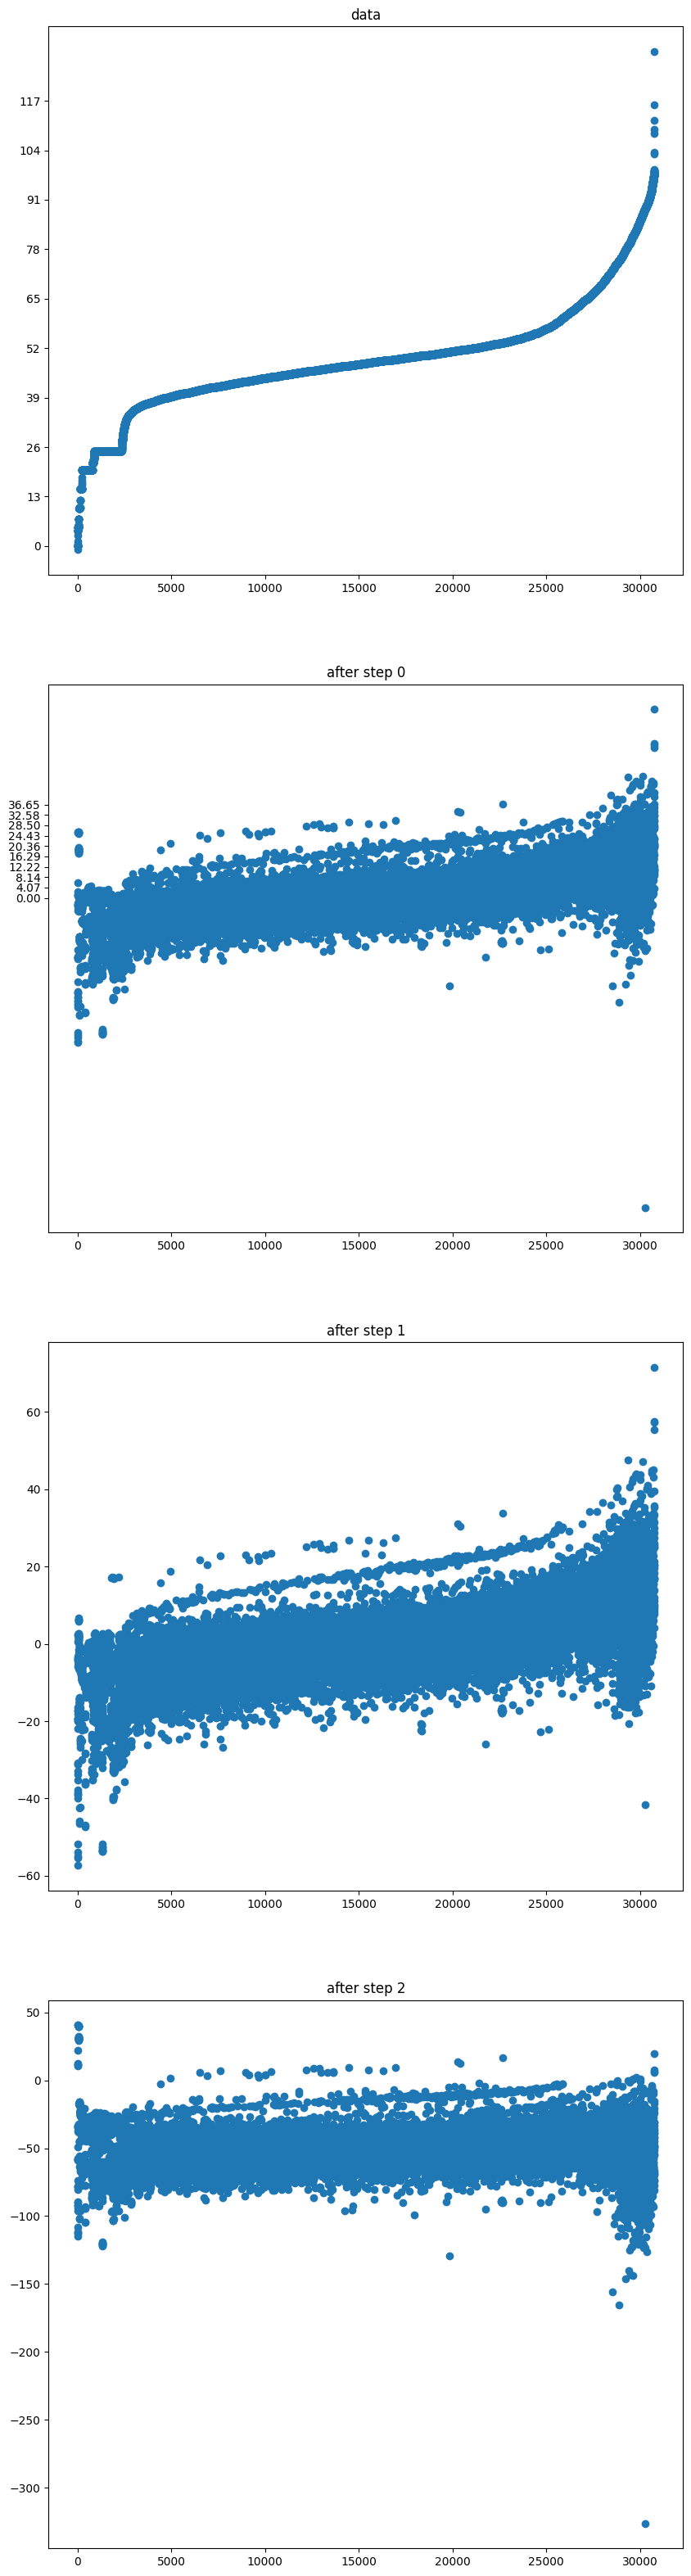

In [ ]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(XGBoost_step+1, 1, figsize=(10, 10 * (XGBoost_step+1)))

y_graf = y[y[:, 0].argsort()]
y_graf[y_graf == -100000] = 0
y_graf[y_graf == 100000] = 0

plt.subplot(XGBoost_step+1,1,1)
y_data = y_graf[:, 0]
plt.scatter( np.arange(0,len(y_data)), y_data)
ax[0].set(yticks=np.arange(0, 10)*np.max(y_data)/10)
plt.title('data')

for model_id in range(XGBoost_step):
  plt.subplot(XGBoost_step+1,1,model_id + 2)
  y_step = y_graf[:, model_id + 1]
  plt.scatter( np.arange(0,len(y_step)), y_step)
  ax[1].set(yticks=np.arange(0, 10)*np.max(y_step)/10)
  plt.title('after step {}'.format(model_id))

plt.show()

In [ ]:
train_dataset_mapped = train_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, XGBoost_step])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE)

val_dataset_mapped = control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
                          inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, XGBoost_step])]
                          , Tout=(tf.float32, tf.float64))
                          )

In [ ]:
from keras.utils.vis_utils import plot_model

MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model XGBoost/{}/'.format(XGBoost_step) 

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS+1), dtype=tf.float32))
model.add(tf.keras.layers.LocallyConnected1D(1, 1, implementation=3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], activation=tf.keras.activations.swish))
model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.linear))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.0001,
      decay_steps=30000*20,
      decay_rate=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
                , loss=tf.keras.losses.MeanSquaredError()
                , metrics=[tf.keras.metrics.MeanAbsoluteError()])
 

print(model.summary())
if DATA_SOURCE in (DATA_SOURCES['Kaggle'], DATA_SOURCES['Gdrive']):
  plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected1d_2 (Loca  (None, 400, 1)           8800      
 llyConnected1D)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               80200     
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 89,201
Trainable params: 89,201
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
if 0:
  #MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221121/'
  model = tf.keras.models.load_model('{}auto_save_model_03.h5'.format(MODEL_DIREKTORY))  

In [ ]:
if 0:
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=30000*90,
        decay_rate=0.1)
  model.optimizer.learning_rate=lr_schedule

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger

#MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221121/'
checkpoint = ModelCheckpoint(MODEL_DIREKTORY + 'auto_save_model_{epoch:02d}.h5', monitor='loss',
    save_best_only=False, mode='auto', save_freq='epoch')
logger = CSVLogger(MODEL_DIREKTORY + 'learning_logs.log', append=True)

In [ ]:
epoch_cnt = 20
fit_history = model.fit(iter(train_dataset_mapped.repeat(epoch_cnt))
                , batch_size=16
                , epochs=epoch_cnt
                , steps_per_epoch=len(train_dataset_mapped)
                #, initial_epoch = 3
                , validation_data = val_dataset_mapped
                , callbacks=[checkpoint, logger]
                )

Epoch 1/20
30774/30774 [==============================] - 627s 20ms/step - loss: 227.6882 - mean_absolute_error: 9.8937 - val_loss: 141.5662 - val_mean_absolute_error: 8.8762
Epoch 2/20
30774/30774 [==============================] - 623s 20ms/step - loss: 133.7801 - mean_absolute_error: 8.5258 - val_loss: 119.7432 - val_mean_absolute_error: 8.3966
Epoch 3/20
30774/30774 [==============================] - 625s 20ms/step - loss: 115.0974 - mean_absolute_error: 8.0568 - val_loss: 115.3956 - val_mean_absolute_error: 8.3843
Epoch 4/20
30774/30774 [==============================] - 403s 13ms/step - loss: 104.0508 - mean_absolute_error: 7.6986 - val_loss: 114.5410 - val_mean_absolute_error: 8.4196
Epoch 5/20
30774/30774 [==============================] - 392s 13ms/step - loss: 95.4839 - mean_absolute_error: 7.3459 - val_loss: 104.2999 - val_mean_absolute_error: 7.8578
Epoch 6/20
30774/30774 [==============================] - 391s 13ms/step - loss: 89.7564 - mean_absolute_error: 7.0950 - val_l

In [ ]:
model.evaluate(control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, XGBoost_step])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE))

In [ ]:
# check 5 examples

for nx in control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS, XGBoost_step])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE).take(5):
  print((model.predict(nx[0]), nx[1]))
  print(model.evaluate(nx[0], nx[1]))

1/1 [==============================] - 0s 133ms/step
(array([[0.9674535]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.92525321])>)
1/1 [==============================] - 0s 162ms/step - loss: 0.0018 - mean_absolute_error: 0.0422
[0.0017808625707402825, 0.04220026731491089]
1/1 [==============================] - 0s 20ms/step
(array([[0.8355437]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.59907735])>)
1/1 [==============================] - 0s 25ms/step - loss: 0.0559 - mean_absolute_error: 0.2365
[0.05591633543372154, 0.23646634817123413]
1/1 [==============================] - 0s 20ms/step
(array([[0.96080166]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.89710976])>)
1/1 [==============================] - 0s 34ms/step - loss: 0.0041 - mean_absolute_error: 0.0637
[0.004056659992784262, 0.06369191408157349]
1/1 [==============================] - 0s 104ms/step
(array([[0.9226131]], dtype=float32), <tf.Tensor: 

#Process Test data for Prediction

In [ ]:
test_enzime_codes = []

with open(test_file, 'r') as f:
  #data = np.array([x.split(',') for x in f.readlines()[1:BATCH_SIZE]])
  while True:
    row = f.readline()
    if not row:
      break
    data_row = row.split(',')  
    #print(data_row)
    if (data_row[0] == 'seq_id'):
      continue
    test_enzime_codes.append([data_row[0], data_row[1], data_row[2]])

In [ ]:
test_labels = []

for specimen in test_enzime_codes:
  one_elem_dataset = tf.data.Dataset.from_tensors((np.array(specimen[1:]), [0.0]))
  test = one_elem_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
            inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])], Tout=(tf.float32, tf.float64)))
  test_labels.append((specimen[0], remove_sigmoid(model.predict(test)[0][0])))


In [ ]:
np_test_labels = np.array(test_labels, dtype=[('seq_id', int),('tm', float)])

In [ ]:
print(np.sort(np_test_labels, order='tm')[::-1])

[(32965, 43.34413076) (33549, 43.22077597) (33066, 42.50219551) ...
 (31721, 31.33321982) (33544, 31.04556545) (31474, 27.61560675)]


In [ ]:
import csv

CSV_FILE = MODEL_DIREKTORY + "prediction.csv"

np.savetxt(CSV_FILE, 
           np.sort(np_test_labels, order='tm')[::-1],
           delimiter =",", 
           header='seq_id,tm',
           comments='',
           fmt ='% s')

# Draw coeffs, if possilbe

In [ ]:
print(fit_history.history.keys())

fig, ax = plt.subplots()

y_data_1 = np.array(fit_history.history['mean_absolute_percentage_error'], dtype=float)
y_data_2 = np.array(fit_history.history['val_mean_absolute_percentage_error'], dtype=float)

plt.scatter( np.arange(0,len(y_data_1)), y_data_1, label='Train')
plt.scatter( np.arange(0,len(y_data_2)), y_data_2, label='Validation')
plt.title('History')
plt.legend()
plt.show()

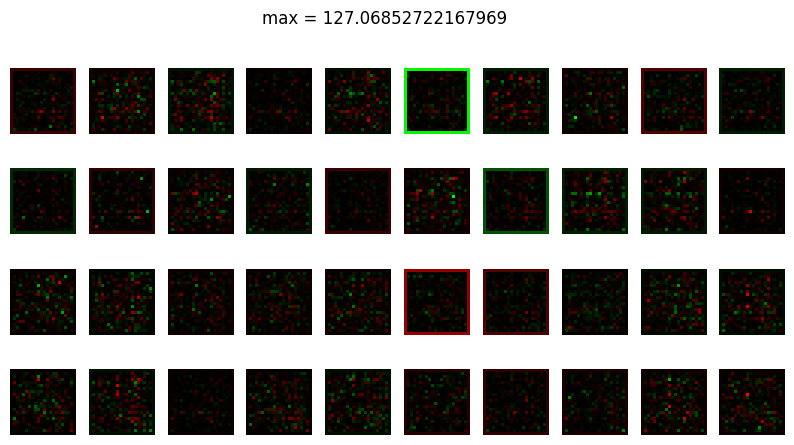

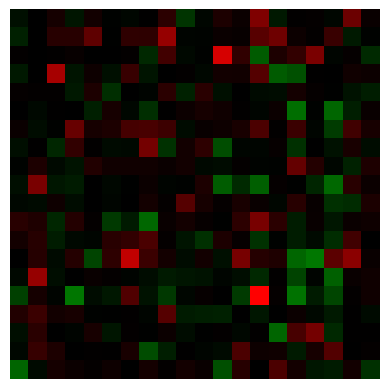

In [ ]:

coefs_layer2 = model.layers[2].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1])
coefs_layer0 = model.layers[0].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , NUMBER_OF_REGIONS+1)

templates_coeffs = model.layers[3].get_weights()[0]

vyhodnoceni = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
colors = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT+2, AMINO_ACIDS_COUNT+2, 3), dtype=float)

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
      vyhodnoceni[r, i, j] = np.sum(coefs_layer0[i, j, :]) * np.sum(coefs_layer2[i, j, r])

#print(vyhodnoceni)
max_coeff = np.max(np.abs(vyhodnoceni))
vyhodnoceni = vyhodnoceni / max_coeff

for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
  for i in range(AMINO_ACIDS_COUNT):
    for j in range(AMINO_ACIDS_COUNT):
      col = vyhodnoceni[r, i, j]
      colors[r, i+1, j+1] = [-col if col < 0 else 0, col if col > 0 else 0, 0]
  template_solor = [-templates_coeffs[r][0] if templates_coeffs[r][0] < 0 else 0, templates_coeffs[r][0] if templates_coeffs[r][0] > 0 else 0, 0]
  colors[r, 0, :] = template_solor
  colors[r, -1, :] = template_solor
  colors[r, :, -1] = template_solor
  colors[r, :, 0] = template_solor

aggregation = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
agg_colors = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT, 3), dtype=float)
for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    aggregation[i, j] = np.sum(vyhodnoceni[:, i, j]*templates_coeffs[:, 0]) 
aggregation = aggregation / np.max(np.abs(aggregation))

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    col = aggregation[i, j]
    agg_colors[i, j, :] = [-col if col < 0 else 0, col if col > 0 else 0, 0]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], figsize=(10, 5))
fig.suptitle('max = {}'.format(max_coeff))

for i in range(HIDDEN_LAYER_SIZE[0]):
  for j in range(HIDDEN_LAYER_SIZE[1]):
    plt.subplot(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], HIDDEN_LAYER_SIZE[1]*i + j + 1)
    plt.imshow(colors[HIDDEN_LAYER_SIZE[1]*i + j, :, :, :], interpolation='none', aspect='equal')
    plt.axis('off')

plt.show()

plt.imshow(agg_colors, interpolation='none', aspect='equal')
plt.axis('off')
plt.show()